Dynamic Customer Segmentation: Feature Engineering (LRFM)

In this stage, we will transform our cleaned and merged dataset into meaningful features for clustering. This is the core of our analysis. The key here is to use a "snapshot date" to make our calculations dynamic. This allows us to re-run the analysis at any point in the future to see how customer segments have changed.

Step 1: Calculate LRFM Scores
We'll aggregate the transaction data for each customer to create the Recency, Frequency, Monetary, and Length scores.


In [28]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load and merge the cleaned datasets
transactions_df = pd.read_csv('Transactions_Cleaned.csv')
demographics_df = pd.read_csv('CustomerDemographic_Cleaned.csv')
final_df = pd.merge(demographics_df, transactions_df, on='customer_id', how='left')
final_df['transaction_date'] = pd.to_datetime(final_df['transaction_date'])

# Define a snapshot date (as pd.Timestamp for consistency)
snapshot_date = pd.Timestamp('2017-01-01')

# Aggregate data to calculate LRFM scores
rfm_df = final_df.groupby('customer_id').agg(
    Recency = ('transaction_date', lambda x: (snapshot_date - x.max()).days),
    Frequency = ('transaction_date', 'count'),
    Length = ('transaction_date', lambda x: (x.max() - x.min()).days if x.count() > 1 else 0),
    Monetary = ('Profit', 'sum')
).reset_index()

# Display the first few rows of the LRFM dataframe
print(rfm_df.head())

   customer_id  Recency  Frequency  Length  Monetary
0            1   -356.0         11     352   3018.09
1            2   -235.0          3     112   2226.26
2            3   -261.0          8     208   3362.81
3            4   -168.0          2      76    220.57
4            5   -347.0          6     286   2394.94


Step 2: Handle Data Skewness
Our LRFM data will likely be skewed, with a few customers having very high scores. Clustering algorithms work better with normally distributed data. We will apply a log transformation to normalize the features.

c:\Users\satav\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\satav\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


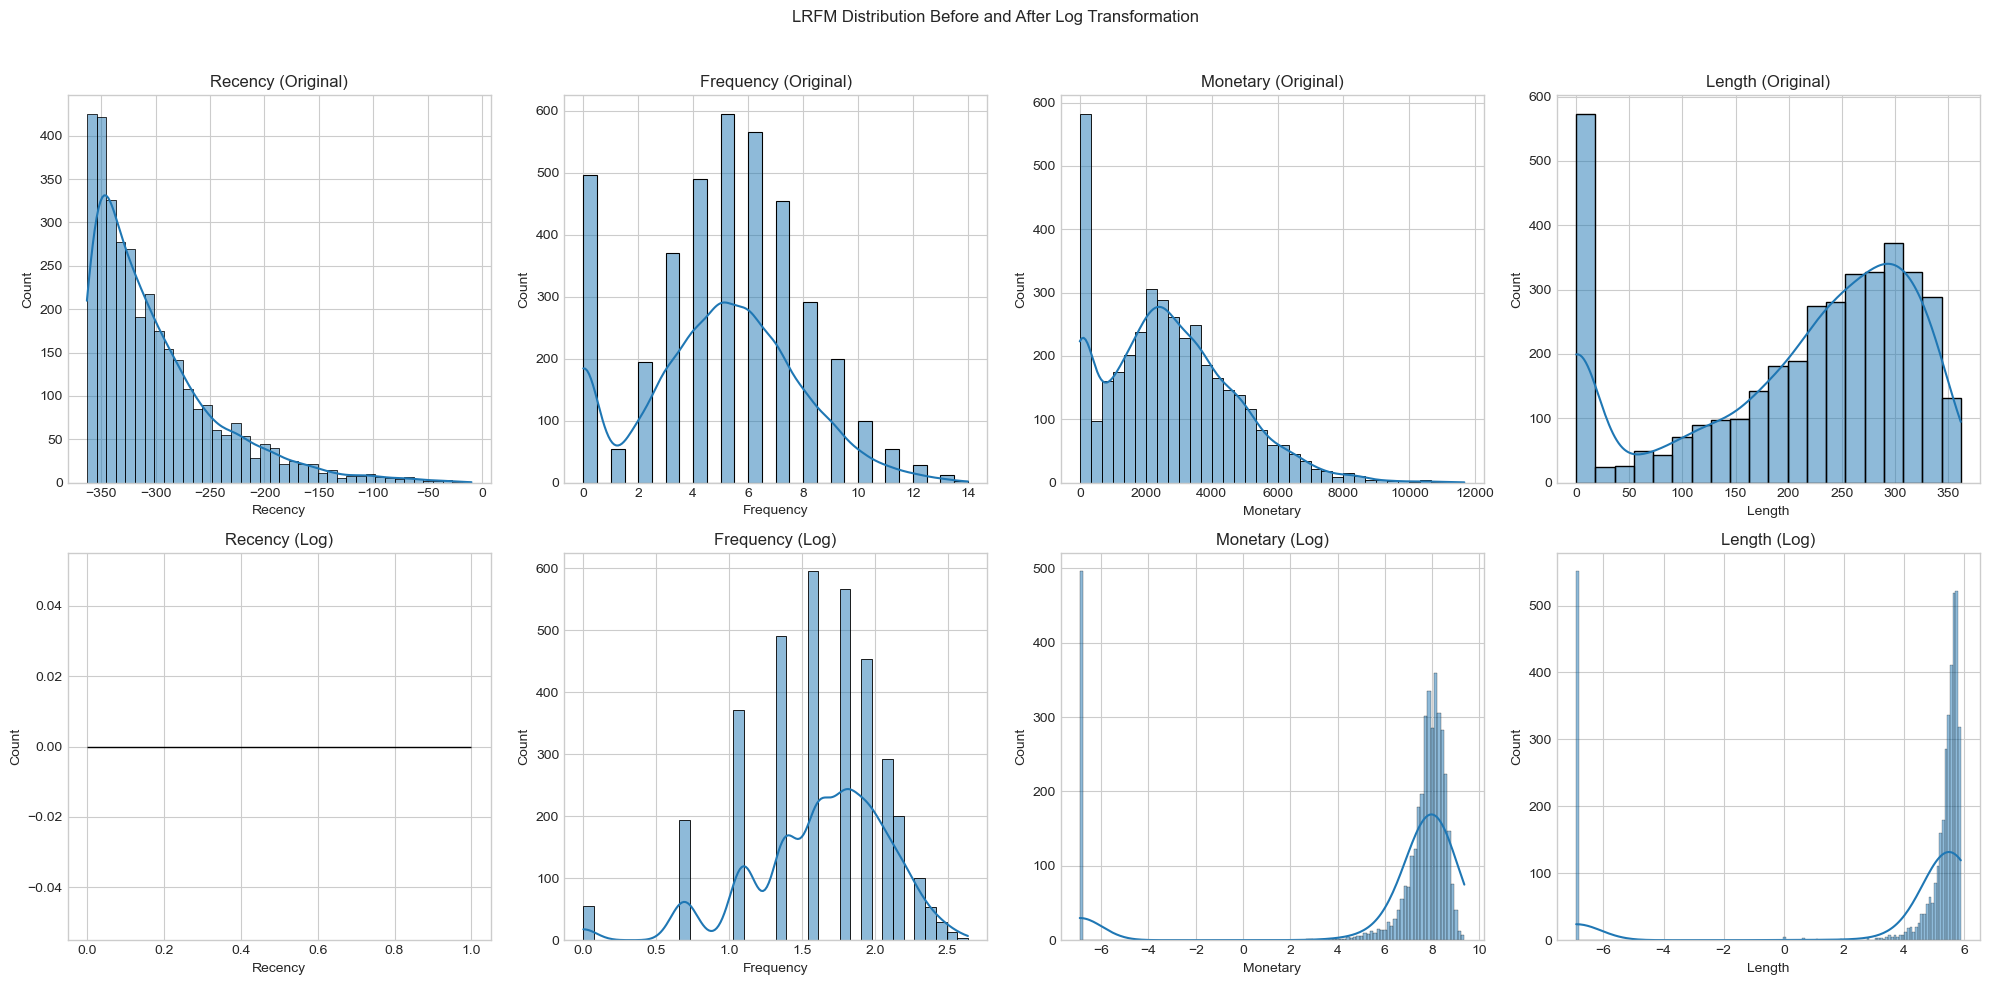

In [29]:
# Create a copy to store the transformed data
rfm_log = rfm_df.copy()

# Apply log transformation to the LRFM features
# We add a small constant (e.g., 0.001) to handle zero values
rfm_log['Recency'] = np.log(rfm_log['Recency'] + 0.001)
rfm_log['Frequency'] = np.log(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log(rfm_log['Monetary'] + 0.001)
rfm_log['Length'] = np.log(rfm_log['Length'] + 0.001)

# Visualize the distributions before and after transformation
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('LRFM Distribution Before and After Log Transformation')

# Before transformation
sns.histplot(rfm_df['Recency'], ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Recency (Original)')
sns.histplot(rfm_df['Frequency'], ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Frequency (Original)')
sns.histplot(rfm_df['Monetary'], ax=axes[0, 2], kde=True)
axes[0, 2].set_title('Monetary (Original)')
sns.histplot(rfm_df['Length'], ax=axes[0, 3], kde=True)
axes[0, 3].set_title('Length (Original)')

# After transformation
sns.histplot(rfm_log['Recency'], ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Recency (Log)')
sns.histplot(rfm_log['Frequency'], ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Frequency (Log)')
sns.histplot(rfm_log['Monetary'], ax=axes[1, 2], kde=True)
axes[1, 2].set_title('Monetary (Log)')
sns.histplot(rfm_log['Length'], ax=axes[1, 3], kde=True)
axes[1, 3].set_title('Length (Log)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()